# choosing between a simple script, a deterministic workflow, a traditional chatbot, a retrieval‐augmented generation (RAG) system, or a full‐blown autonomous agent

To clarify this choice, consider four key *factors*:
- the variability of your inputs,
- the complexity of the reasoning required,
- any performance or compliance constraints,
- the ongoing maintenance burden.

If your inputs are fully predictable and every possible output can be described in advance, a handful of lines of procedural code are often faster, cheaper, and far easier to test than an ML–based pipeline. For example, parsing a log file that always follows the format “YYYY‐MM‐DD HH:MM:SS—message” can be handled reliably with a small regular‐expression‐based parser in Python or Go. Likewise, if your application demands millisecond‐level latency—such as an embedded system that must react to sensor data in real time—there simply isn’t time for a language model API call. In such cases, traditional code is the right choice.

regulated domains (medical devices, aeronautics, certain financial systems) often require fully deterministic, auditable decision logic—black‐box neural models won’t satisfy certification requirements.


If any of these conditions hold
- deterministic inputs,
- strict performance
- explainability needs
- static problem domain
plain code is almost always preferable to a foundation model.

Deterministic workflows make sense whenever you can list all decision branches in advance and you need tight, auditable control over each branch. In such scenarios, workflows scale more naturally than large, ad hoc scripts but still avoid the complexity and cost of running an agentic pipeline.



If your primary need is to let users ask questions about a knowledge base—say, searching a product manual, a legal archive, or corporate wikis—a RAG system can embed documents into a vector store, retrieve relevant passages in response to a query, and generate coherent, context‐aware answers.

RAG systems do not independently decide on follow‐up actions (like filing a ticket or scheduling a callback); they simply surface information. A traditional chatbot or RAG approach makes sense when the task is primarily question‐answering over structured or unstructured content, with limited need for external API calls or decision orchestration

Maintenance costs are lower than for agents—your main overhead lies in keeping document embeddings up to date and refining prompts—but you sacrifice the agent’s ability to plan multistep workflows or learn from feedback loops.

Need for Agentic flows come when inputs are unstructured, novel, or highly variable, and because you require dynamic, multistep planning or continuous learning from feedback.


# Degrees of Autonomy
In an agentic workflow, the degrree of autonomy can vary significantly

Simple agentic workflow like `write an essay of Blackholes` is a low-autonomy task, where the agent is given a specific task and is expected to complete it with minimal intervention. We might have simple deterministic steps to follow, such as
* [LLM] write the query to search for the topic
* websearch the topic,
* Webscrape the content,
* [LLM] writing the content

More autonomous workflow for same task might involve
* [LLM] Determine which tool to use to lookup the topic,
* [LLM] once decided to use websearch, write the query to search for the topic,
* websearch the topic,
* [LLM] Determine the tool to use like pdf2txt, webfetch
* Webscrape the content,
* [LLM] outlining the essay,
* [LLM] writing the content (draft)
* [LLM] proofreading and improve the draft
* [LLM] writing the final essay.

## Task Decomposition

![image.png](../resources/img.png)

## Reflection Pattern
Agentic workflows are powerful, but they can also be unpredictable. To mitigate this, consider implementing a reflection pattern, where the agent periodically reviews its actions and decisions. This can help catch errors early and ensure that the workflow stays on track.

== Chart Generation Agentic Workflow

- Generate an initial version (V1): Use a Large Language Model (LLM) to create the first version of the plotting code.
- Execute code and create chart: Run the generated code and display the resulting chart. _(check everywhere)_
- Reflect on the output: Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).
- Generate and execute improved version (V2): Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

In [1]:
# Standard library imports
import re
import json

from numpy.random import sample

# Local helper module
import utils


In [2]:
df = utils.load_and_prepare_data("../resources/1.csv")
utils.print_html(df.sample(5), title="Sample Coffee Sales Data")

,date,time,cash_type,card,price,coffee_name,quarter,month,year
2208,2024-11-04,14:42,card,ANON-0000-0000-0854,3.086,Americano with Milk,4,11,2024
2650,2024-12-27,13:59,card,ANON-0000-0000-1051,3.086,Americano with Milk,4,12,2024
185,2024-03-27,07:47,card,ANON-0000-0000-0082,3.380,Americano with Milk,1,3,2024
1282,2024-08-15,08:03,card,ANON-0000-0000-0508,3.282,Cappuccino,3,8,2024
2764,2025-01-13,06:08,card,ANON-0000-0000-0533,3.086,Americano with Milk,1,1,2025


In [3]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

In [4]:
# Generate initial code
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
    model="gpt-4.1-dz",
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code")


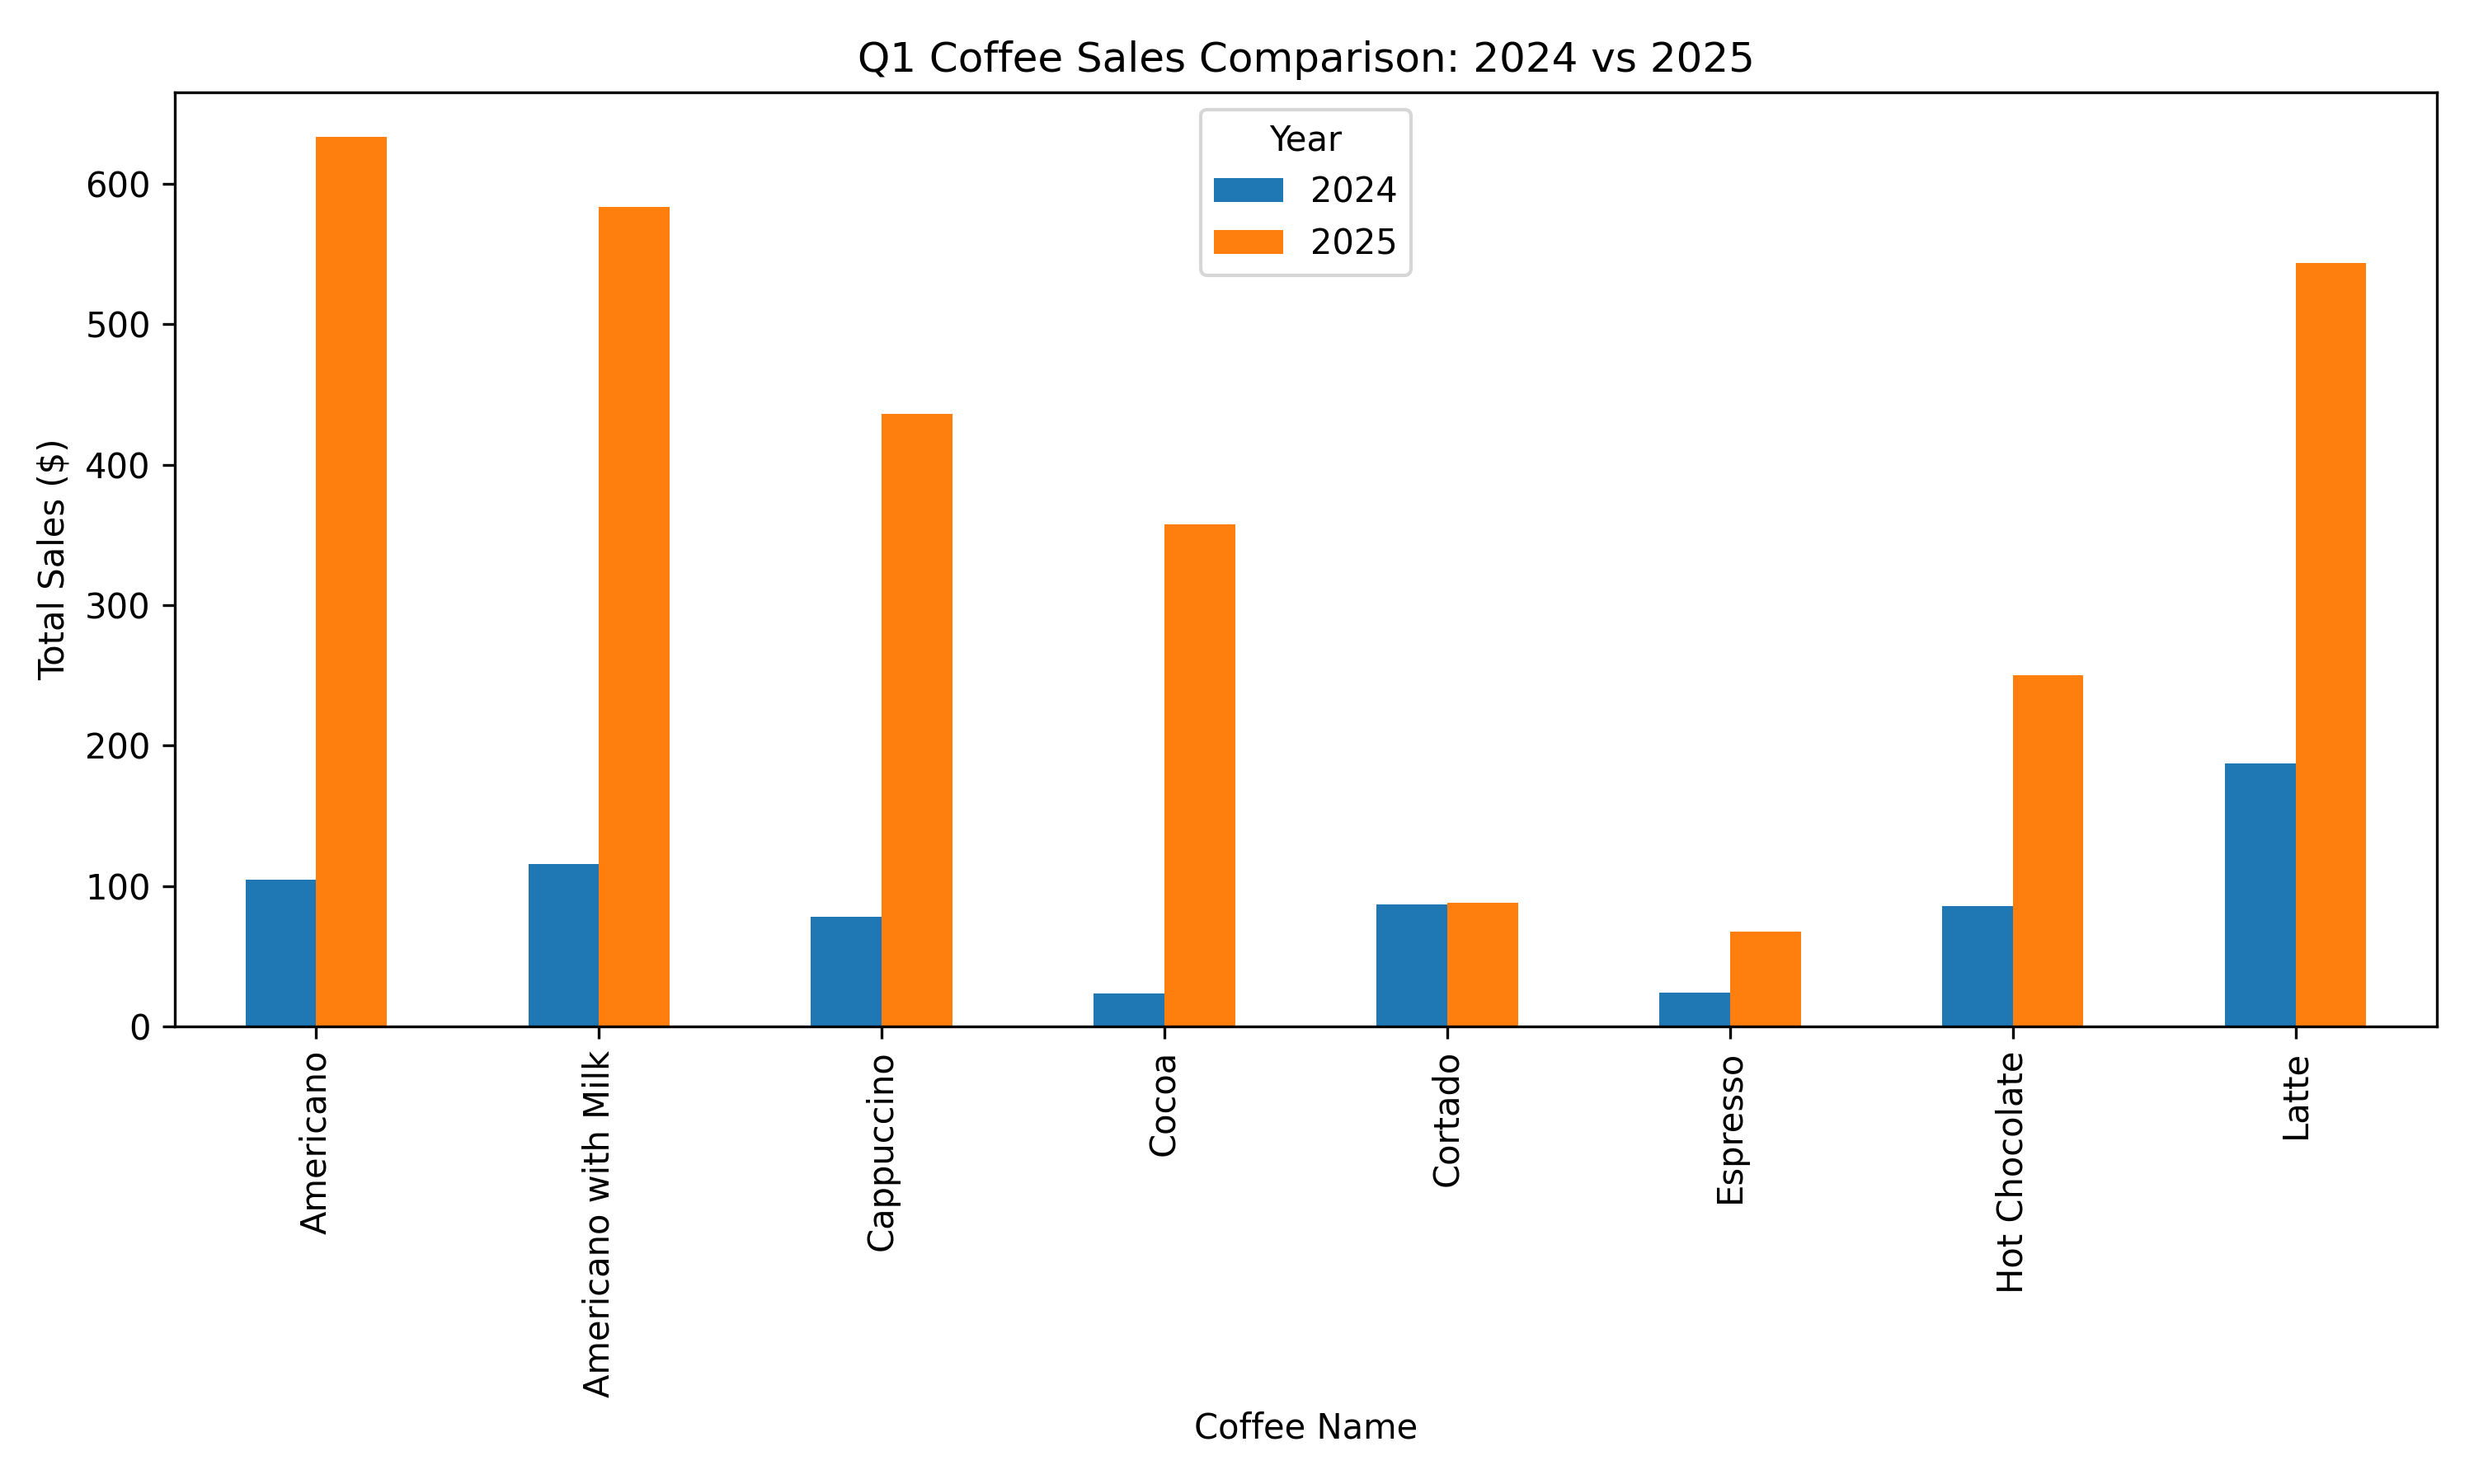

In [5]:
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

In [6]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction,
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)


    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """


    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code


In [7]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
    model_name="o4-mini",
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")


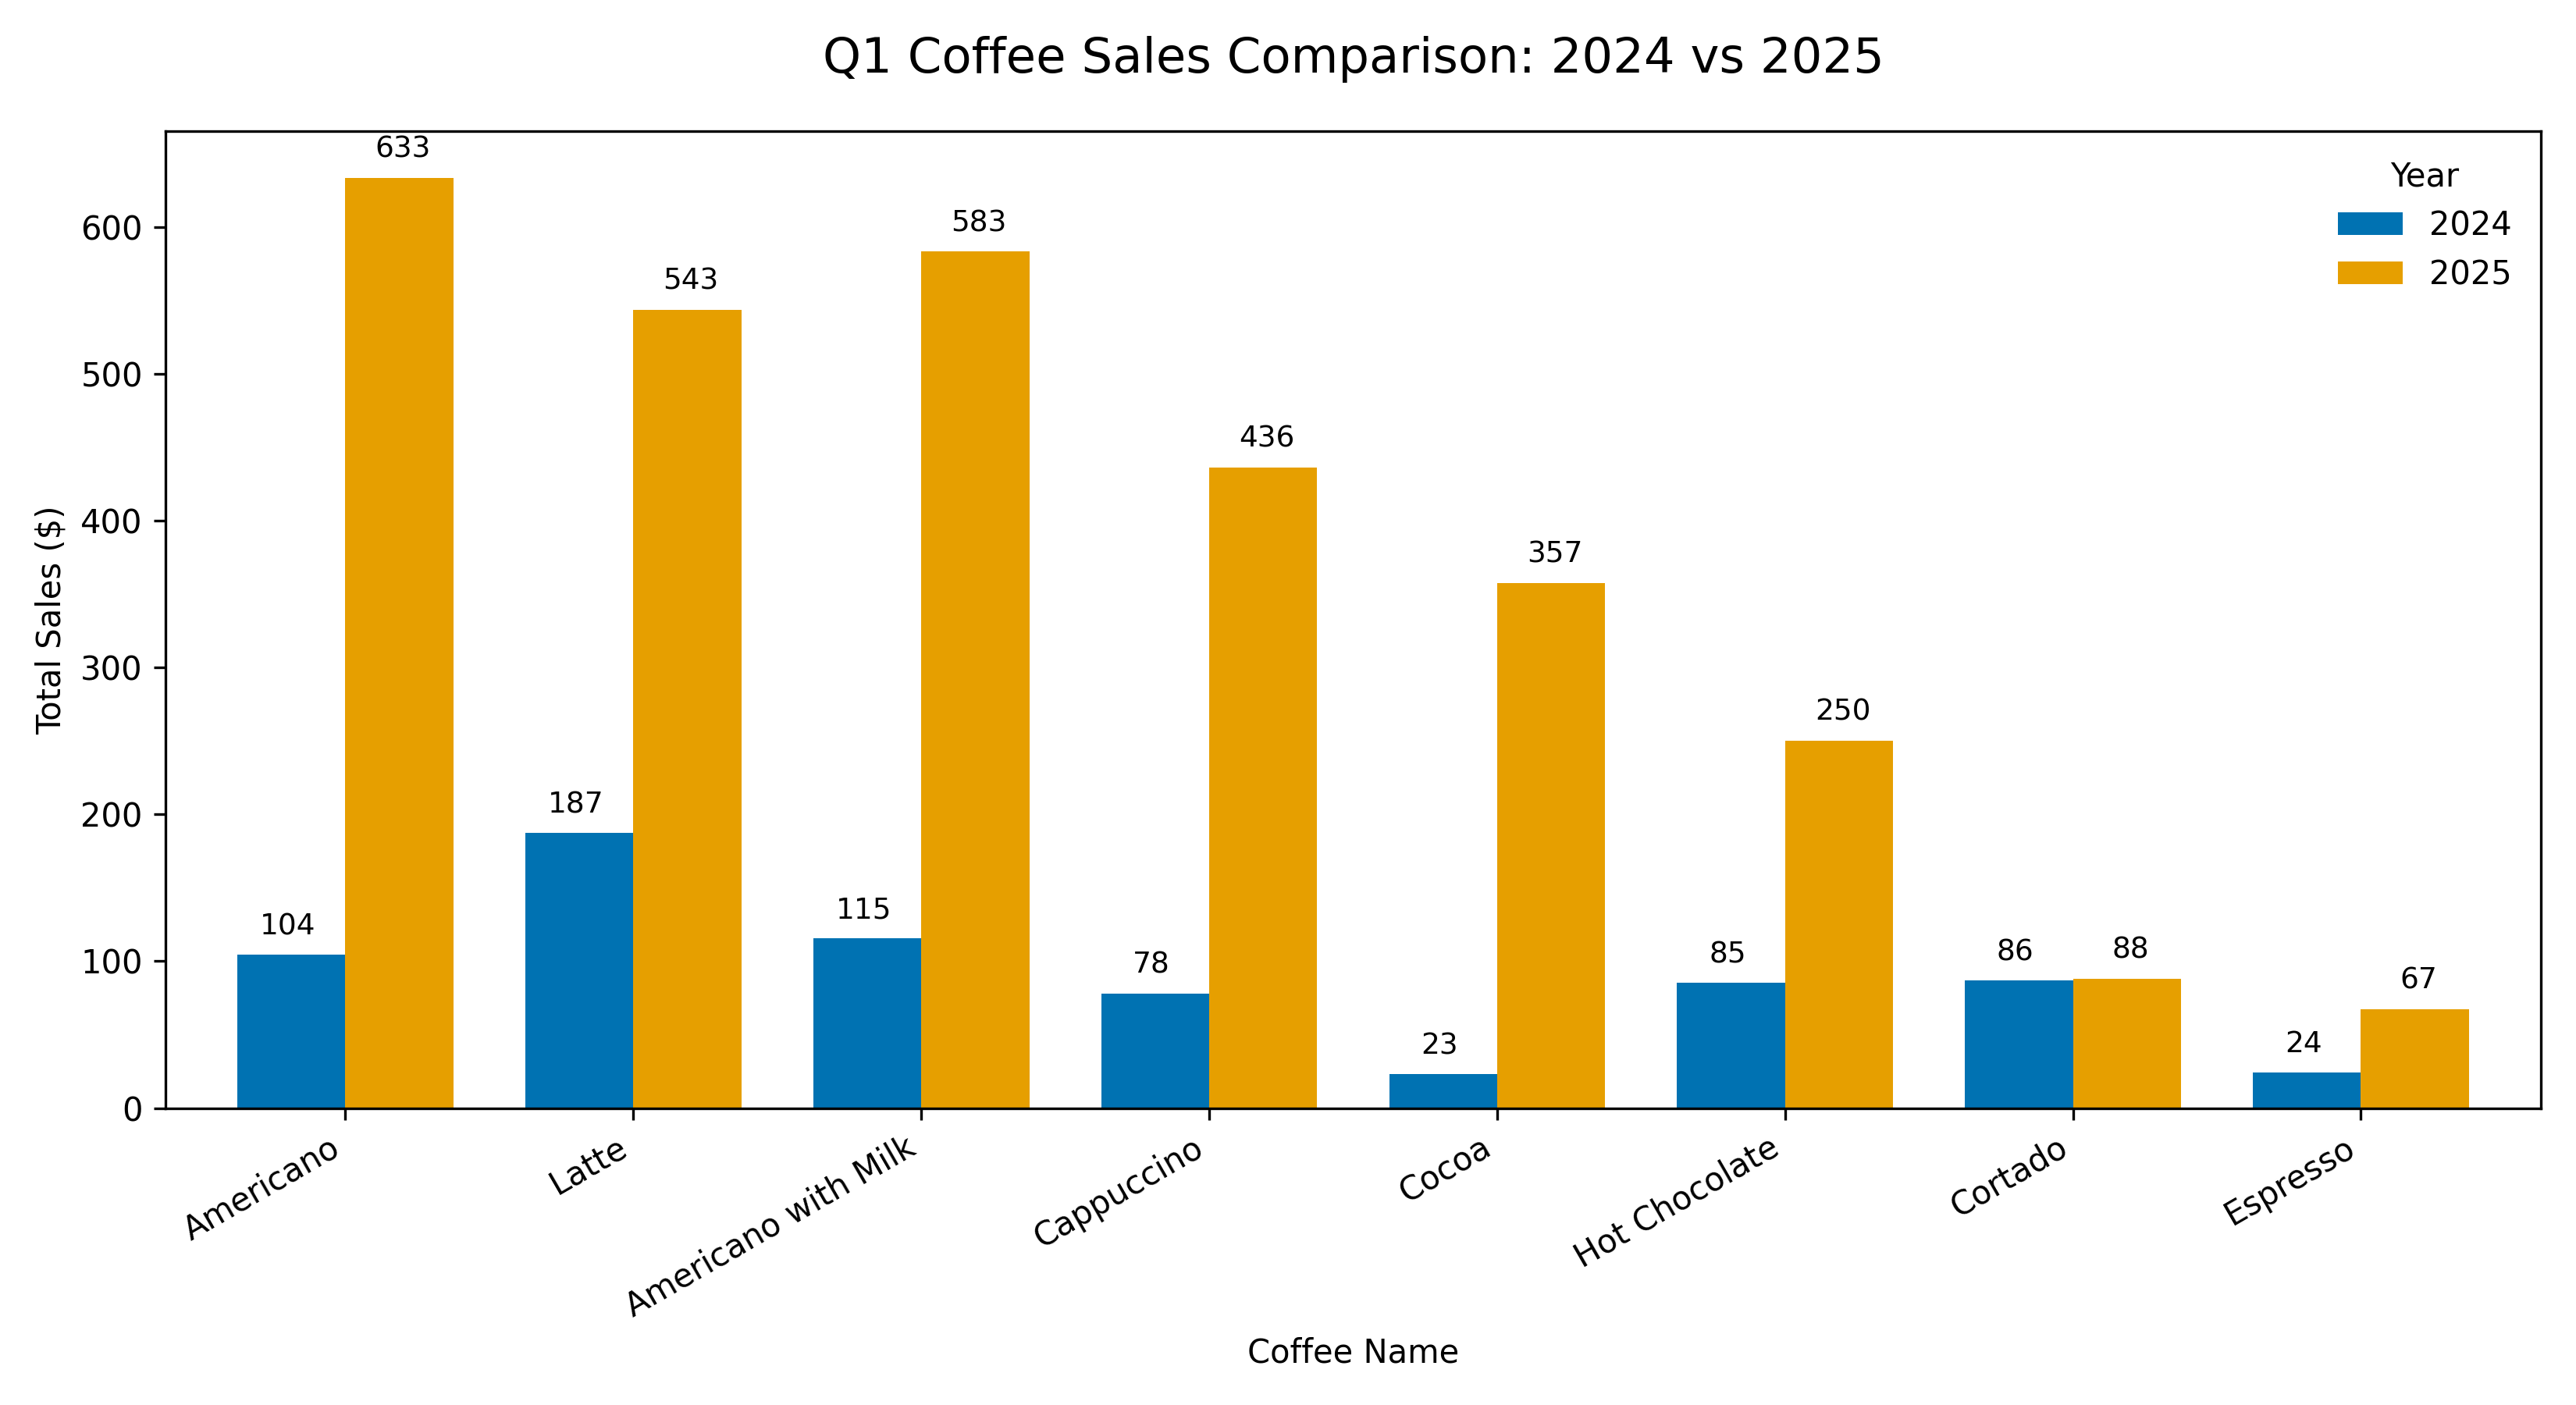

In [8]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

In [9]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }


,date,time,cash_type,card,price,coffee_name,quarter,month,year
2406,2024-11-26,08:27,card,ANON-0000-0000-0903,3.576,Cocoa,4,11,2024
1249,2024-08-12,12:03,card,ANON-0000-0000-0493,2.792,Americano with Milk,3,8,2024
1702,2024-09-27,09:28,card,ANON-0000-0000-0675,3.282,Cappuccino,3,9,2024
1332,2024-08-20,12:01,card,ANON-0000-0000-0527,2.302,Americano,3,8,2024
3240,2025-02-24,11:50,card,ANON-0000-0000-1177,3.576,Latte,1,2,2025



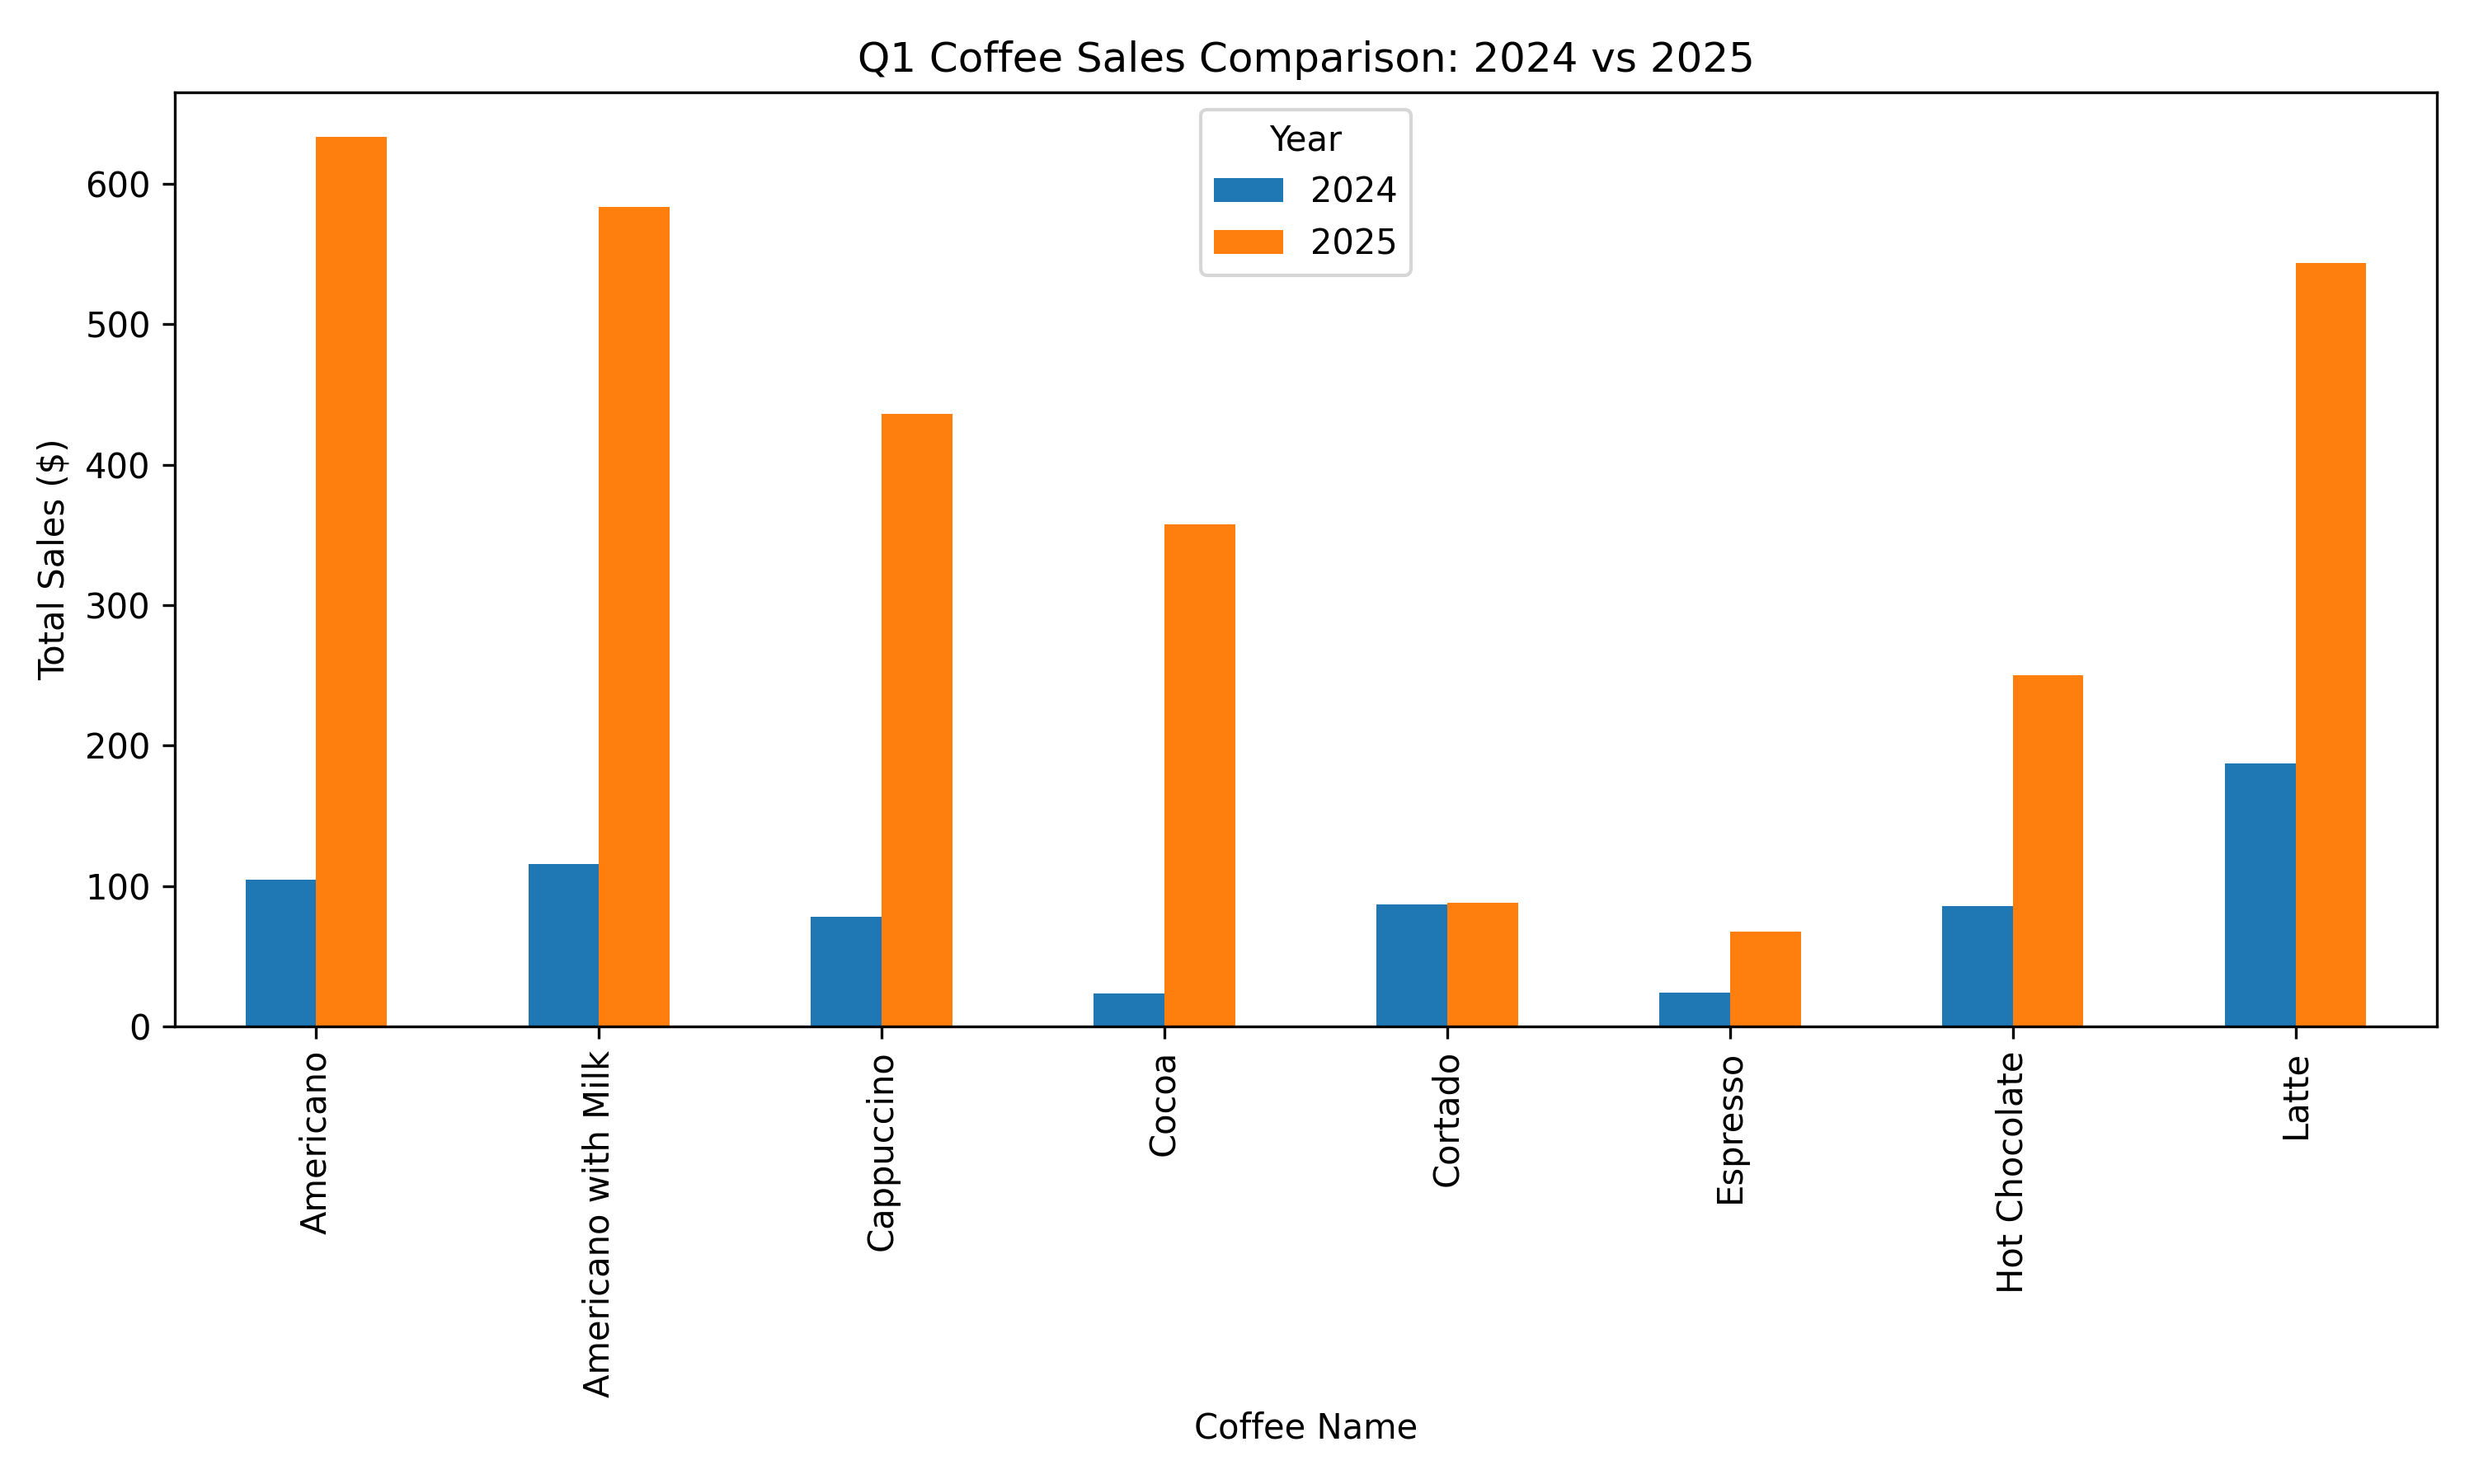


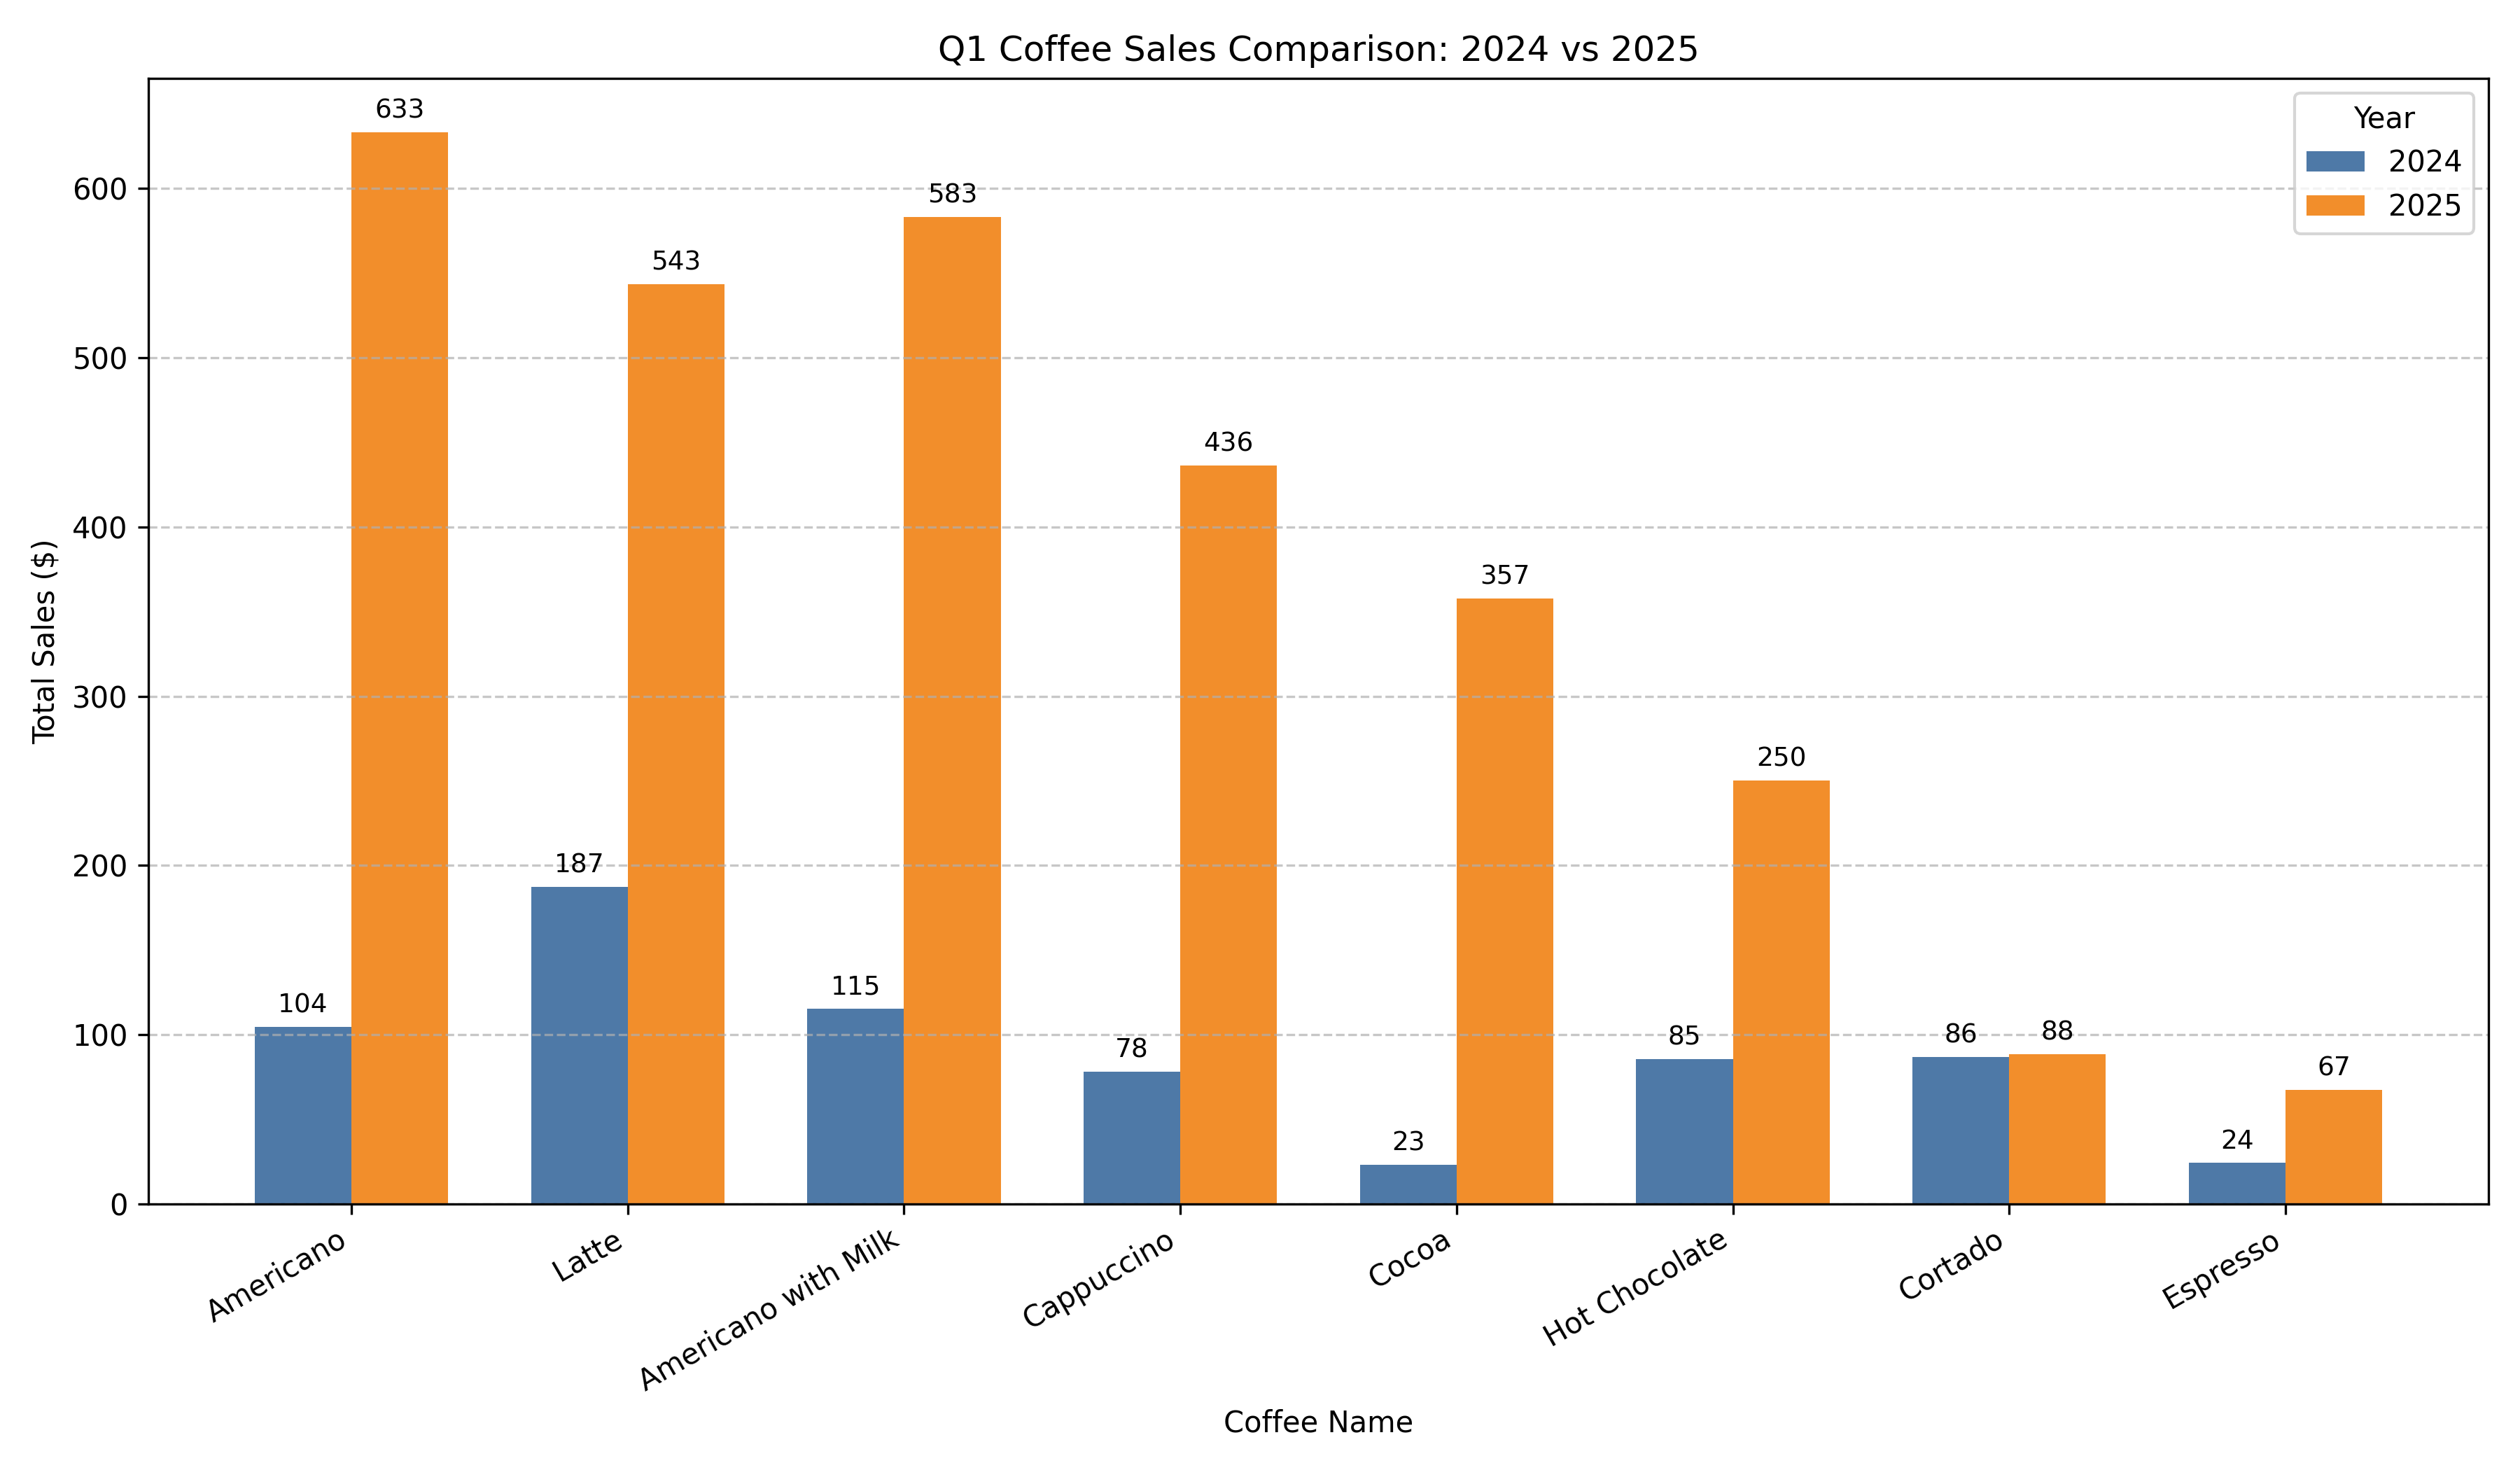

In [11]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." # write your instruction here
generation_model="gpt-4o-mini"
reflection_model="o4-mini"
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="../resources/1.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)